In [41]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
import torch
from torch import nn

In [43]:
n_samples = 1000
x,y = make_circles(n_samples,noise=0.03,random_state = 42)
len(x),len(y)

(1000, 1000)

In [44]:
#now let's view the first 5 X and y values.
print(f"First 5 x features:\n{x[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 x features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [45]:
# Make DataFrame of circle data
circles = pd.DataFrame({"x1":x[:,0],"x2":x[:,1],"label":y})
circles

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [46]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

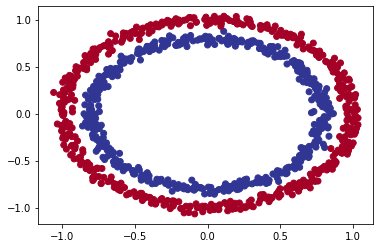

In [47]:
# Visualize with a plot
plt.scatter(x=x[:, 0], 
            y=x[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

**Input and output shapes**

In [48]:
# Check the shapes of our features and labels
x.shape, y.shape

((1000, 2), (1000,))

In [49]:
# View the first example of features and labels
x_sample = x[0]
y_sample = y[0]
print(f"Values for one sample of x: {x_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of x: {x_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of x: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of x: (2,) and the same for y: ()


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

**Turn data into tensors**

In [50]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [51]:
x[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

**create train and test splits**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

**Building a model**

In [53]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's create a model class that:
1.   Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2.   Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3.   Defines a forward() method containing the forward pass computation of the model.
4.   Instantiates the model class and sends it to the target device.





In [54]:
# 1. Construct a model class that subclasses nn.Module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling x and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (x), produces 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [55]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [56]:
# Replicate CircleModel with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

**Setup loss function and optimizer**

In [57]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [58]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

**Train model 1.1**

PyTorch training loop steps


1.   **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

2.   **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

3.   **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

4.   **Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

5.   **Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).









**Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)**

**Logits are the raw outputs of our model without training the model**

Before we the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [59]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [60]:
#To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function. Let's try it out.
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)

In [61]:
#To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)
print(y_preds)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [62]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

**Train model 1.2**

In [63]:
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train) 
  loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                  y_train) 
  acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred) 

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262, Test acc: 53.00%


**Make predictions and evaluate the model**

From the metrics it looks like our model is random guessing.

How could we investigate this further?

"Let's Visualize it"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

In [64]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [65]:
from helper_functions import plot_predictions,plot_decision_boundary

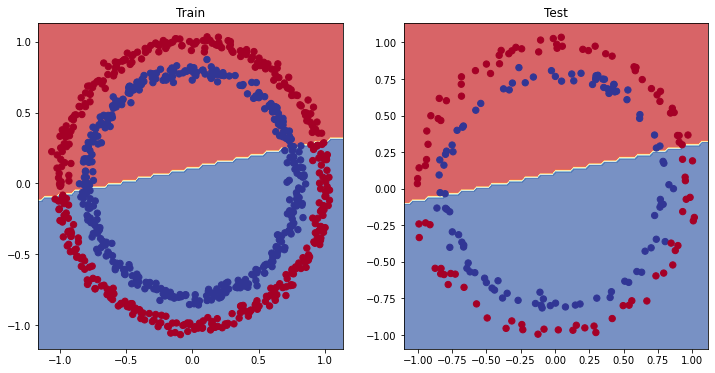

In [66]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

**Improving a model (from a model perspective)**

Let's try to fix our model's underfitting problem.

Focusing specifically on the model (not the data), there are a few ways we could do this.

  Model improvement technique*	                              What does it do?
1. **Add more layers**	Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper.
2. **Add more hidden **units	Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.
3. **Fitting for longer** (more epochs)	Your model might learn more if it had more opportunities to look at the data.
4. **Changing the activation functions**	Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).
5. **Change the learning rate**	Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.
6. **Change the loss function**	Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.
7. **Use transfer learning**	Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.

In [67]:
#We'll follow the same steps we did above but with a few changed hyperparameters.

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [68]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [69]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69713, Accuracy: 50.00% | Test loss: 0.69594, Test acc: 50.00%
Epoch: 100 | Loss: 0.69327, Accuracy: 49.62% | Test loss: 0.69334, Test acc: 54.00%
Epoch: 200 | Loss: 0.69311, Accuracy: 49.88% | Test loss: 0.69357, Test acc: 50.00%
Epoch: 300 | Loss: 0.69305, Accuracy: 50.62% | Test loss: 0.69384, Test acc: 49.50%
Epoch: 400 | Loss: 0.69301, Accuracy: 50.50% | Test loss: 0.69407, Test acc: 46.00%
Epoch: 500 | Loss: 0.69300, Accuracy: 51.00% | Test loss: 0.69425, Test acc: 47.50%
Epoch: 600 | Loss: 0.69299, Accuracy: 51.50% | Test loss: 0.69438, Test acc: 47.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 50.88% | Test loss: 0.69447, Test acc: 46.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69453, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69458, Test acc: 46.00%


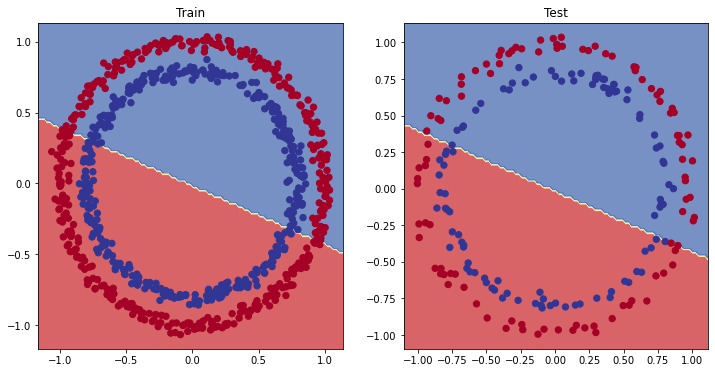

In [70]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

**Preparing data to see if our model can model a straight line**

In [71]:
#Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [72]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


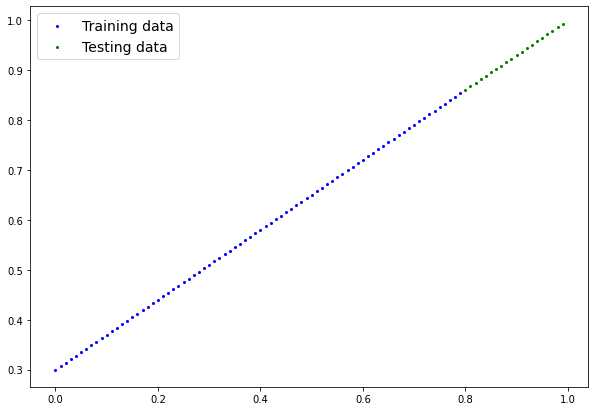

In [73]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

In [74]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [75]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [76]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


In [78]:
model_2.eval()
with torch.inference_mode():
  test_pred = model_2(X_test_regression)

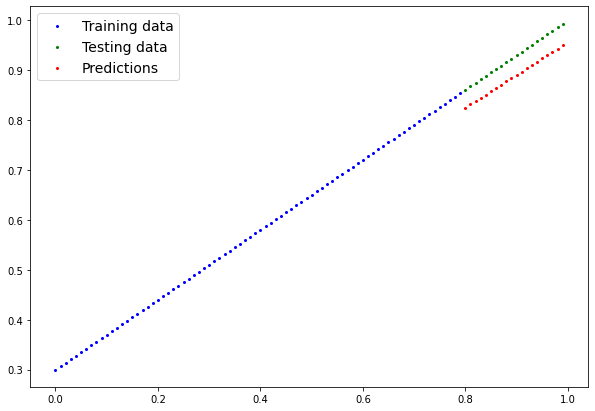

In [83]:
cpu_device="cpu"
plot_predictions(train_data=X_train_regression.to(cpu_device),
    train_labels=y_train_regression.to(cpu_device),
    test_data=X_test_regression.to(cpu_device),
    test_labels=y_test_regression.to(cpu_device),predictions=test_pred.to(cpu_device)
)